In [1]:
import sys
sys.executable

'/Users/jurriaan/opt/anaconda3/envs/conda_unosatenv/bin/python'

In [2]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from os.path import join
import descartes
from PIL import Image

#import earthpy.spatial as es
#import earthpy.plot as ep
# import earthpy.clip as ec
# import earthpy.mask as em

import fiona 
import pyproj
import time

import warnings

In [3]:
rio.__version__

'1.1.0'

In [4]:
import keras
from keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [5]:
# see: https://github.com/karolzak/keras-unet
from keras_unet.models import satellite_unet 
from keras_unet.losses import jaccard_distance
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.utils import get_augmented

In [6]:
warnings.simplefilter("ignore")

In [73]:
# local paths
path_data = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset'
area = 'Mosul_2015'
path_file = 's1tiling_S1A_IW_GRDH_1SDV_20150108T030926_20150108T030951_004074_004EC3_B908/38SLF/s1a_38SLF_vv_DES_20150108t030926.tif'
path_file_border_mask = 's1tiling_S1A_IW_GRDH_1SDV_20151222T030932_20151222T030957_009149_00D2A0_F04A/38SLF/s1a_38SLF_vv_DES_20151222t030932_BorderMask.tif'

path_test_raster_file = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Nasiryah_2015/20150114_38RPV/s1a_38RPV_vh_ASC_20150114t145841.tif'
path_test_shape_file = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/Train_Dataset/Nasiryah_2015/38RPV_Nasiryah.shp'

shape_file = '38SLF_Mosul.shp'
file_label = shape_file[-0:-4] + path_file[-19:-4]

path_raster = join(path_data, area, path_file)
path_border_mask = join(path_data, area, path_file_border_mask)
path_shape_file = join(path_data, area, shape_file)
output = join('/Volumes/other/datasets_and_ML/UNOSAT_Challenge/output_test', 'mosul_test.tif')

The idea is to make data slices of 128x128 (or 64x64 or 100*100) pixels. Each slice a training sample. The labels are the slices of the mask which filters the urban areas belonging to the data array. The label vector has a length of 128*128. In other words: For each pixel a prediction is made whether it is an urban pixel or not. Eventually we can group the mask pixels to sets of 2x2 or 3x3 in order to reduce the vector label.

In [74]:
polygons = gpd.read_file(path_shape_file)
raster_obj= rio.open(path_raster)

In [75]:
polygons_test = gpd.read_file(path_test_shape_file)
raster_obj_test = rio.open(path_test_raster_file)

## process raster: clipping, transform, normalization

In [12]:
np_arr_read = raster_obj.read()

In [13]:
np_arr = np_arr_read[0]

In [14]:
sum(sum(np_arr))

27718424.943359375

In [15]:
raster_obj.crs

CRS.from_epsg(32638)

In [16]:
np_arr.max(), np_arr.min(), np.median(np_arr), np.std(np_arr)

(12941.945, -66.68149, 0.15241046, 2.2706022)

In [17]:
# need to clip and stretch contrast of  figure
clip_min=0
clip_max=2

arr_clip = np.clip(np_arr, clip_min, clip_max)

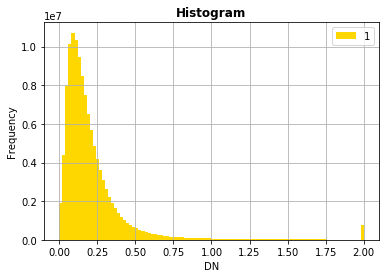

In [18]:
rio.plot.show_hist(arr_clip, bins=100)

In [19]:
def exponent(x, a, b):
    return a*x**b

In [20]:
def log(x, a, b):
    return np.log(a*x + b)

In [21]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

In [22]:
a = 1
b = 0.5

a_l = 1
b_l = 0.1

array_exp = exponent(arr_clip, a, b)
array_log = log(arr_clip, a_l, b_l)
np_arr_norm = normalize(arr_clip)
np_arr_exp_norm = normalize(array_exp)
np_arr_log_norm = normalize(array_log)

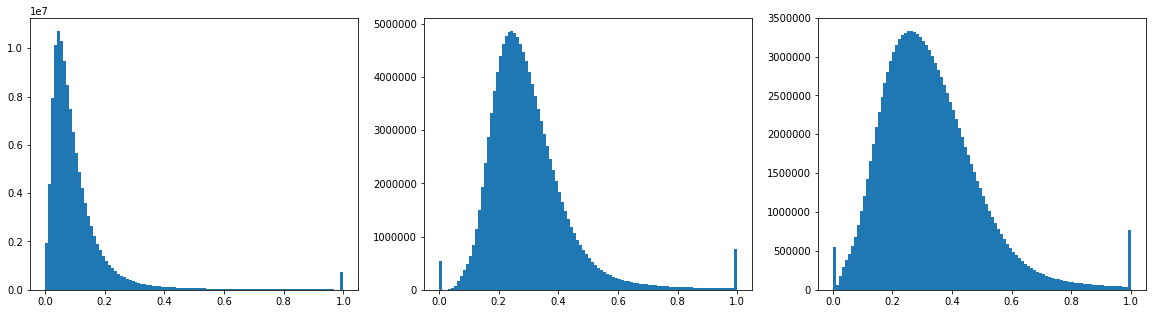

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.hist(np_arr_norm.flatten(), bins=100);
ax2.hist(np_arr_exp_norm.flatten(), bins=100);
ax3.hist(np_arr_log_norm.flatten(), bins=100);

## Masking a raster using  shapefile => use this for the input data and labels

In [19]:
#https://rasterio.readthedocs.io/en/stable/topics/masking-by-shapefile.html

In [24]:
shapes = polygons.geometry

In [25]:
with fiona.open(path_shape_file, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [65]:
shapes

[{'type': 'Polygon',
  'coordinates': [[(43.779087810840636, 37.03939453669721),
    (43.779896284993086, 37.03939453669721),
    (43.779896284993086, 37.03903521485169),
    (43.779087810840636, 37.03903521485169),
    (43.779087810840636, 37.03939453669721)]]},
 {'type': 'Polygon',
  'coordinates': [[(43.75411494257608, 37.03903521485169),
    (43.75465392534438, 37.03903521485169),
    (43.75465392534438, 37.0389453843903),
    (43.75411494257608, 37.0389453843903),
    (43.75411494257608, 37.03903521485169)]]},
 {'type': 'Polygon',
  'coordinates': [[(43.75303697703948, 37.0389453843903),
    (43.75330646842363, 37.0389453843903),
    (43.75330646842363, 37.038675893006165),
    (43.75303697703948, 37.038675893006165),
    (43.75303697703948, 37.0389453843903)]]},
 {'type': 'Polygon',
  'coordinates': [[(43.735969189376654, 37.038855553928926),
    (43.736238680760806, 37.038855553928926),
    (43.736238680760806, 37.038675893006165),
    (43.735969189376654, 37.038675893006165),
 

In [26]:
t0 = time.time() # takes about 8 mins
polygons_resh = polygons.to_crs(raster_obj.crs)
print('takes:', time.time() - t0)

takes: 0.920814037322998


In [27]:
geom = polygons_resh.iloc[0]['geometry']

In [28]:
polygons_resh.head()

,DN,geometry
0,255,"POLYGON ((391421.828 4099939.450, 391493.730 4..."
1,255,"POLYGON ((389200.322 4099928.390, 389248.258 4..."
2,255,"POLYGON ((389104.321 4099919.681, 389128.289 4..."
3,255,"POLYGON ((387586.238 4099929.754, 387610.206 4..."
4,255,"POLYGON ((391733.532 4099945.422, 391805.434 4..."


In [29]:
print(geom)

POLYGON ((391421.8279754725 4099939.449924852, 391493.7302158377 4099938.527171472, 391493.2188013538 4099898.663663579, 391421.3162219654 4099899.586413643, 391421.8279754725 4099939.449924852))


In [30]:
geoms = polygons_resh['geometry']

In [31]:
# https://gis.stackexchange.com/questions/273390/extract-polygon-pixels-using-lazy-reading-in-rasterio
polygon_mask = rio.features.geometry_mask(geometries=geoms,
                                       out_shape=(raster_obj.height, raster_obj.width),
                                       transform=raster_obj.transform,
                                       all_touched=False,
                                       invert=True)
print(polygon_mask.shape)

(10980, 10979)


In [32]:
polygon_mask.shape, np_arr_log_norm.shape, np.sum(polygon_mask)

((10980, 10979), (10980, 10979), 4316046)

In [33]:
polygon_mask_int = np.multiply(polygon_mask, 1)

In [34]:
sum(sum(polygon_mask_int))

4316046

In [35]:
np_arr_norm_mask_int = np.multiply(np_arr_log_norm, polygon_mask_int)

In [36]:
np_arr_norm_mask_int.shape

(10980, 10979)

In [37]:
np_arr_norm_mask_int

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
polygon_mask_int.shape

(10980, 10979)

# prepare  data

In [39]:
np_arr_log_norm.shape

(10980, 10979)

In [40]:
np_arr_log_norm.shape[0] / 128

85.78125

In [41]:
np_arr_crop = np_arr_log_norm[:-100,:-99]
np_arr_crop.shape

(10880, 10880)

In [42]:
polygon_mask_int_crop = polygon_mask_int[:-100,:-99]

In [43]:
size_sample = (128, 128)
n_samples = 85*85

#### check reordering array

In [44]:
test_arr0 = np.linspace(0,35,36).reshape([6,6])
test_arr0

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35.]])

In [45]:
# reshape
n_test_arr = 3*3
size_test_arr = (2,2)
test_arr0.reshape(n_test_arr, size_test_arr[0], size_test_arr[1]);
# nope

In [46]:
# https://stackoverflow.com/questions/11105375/how-to-split-a-matrix-into-4-blocks-using-numpy/51914911#51914911?newreg=399264720ba84b0cb7e27c4fb121322d
def split_array(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

In [47]:
split_array(test_arr0, 2,2);
# yes, awesome!

#### for real...

In [48]:
Xdata = split_array(np_arr_crop, size_sample[0], size_sample[1])
Ydata = split_array(polygon_mask_int_crop, size_sample[0], size_sample[1])

In [49]:
Xdata.shape, Ydata.shape

((7225, 128, 128), (7225, 128, 128))

In [50]:
def visualize_sample(np_arr, poly_mask, figsize=(10,10), linewidth=1):
    fig, ax = plt.subplots(figsize=figsize)
    ax.contour(poly_mask, 1, colors='red', linewidth=linewidth)
    ax.imshow(np_arr)

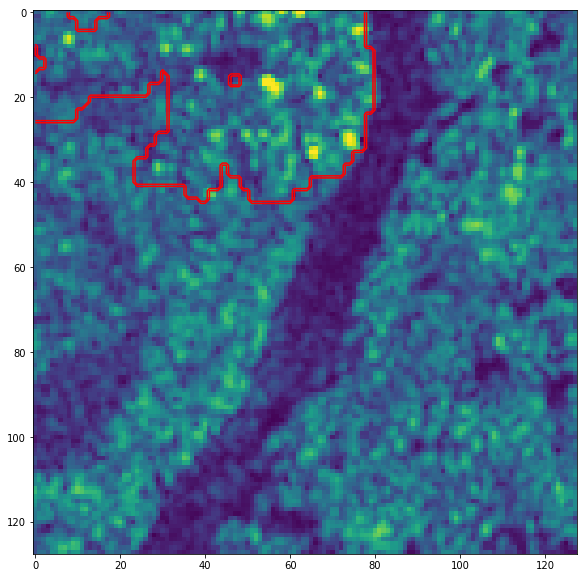

In [51]:
i_show = 5000
visualize_sample(Xdata[i_show], Ydata[i_show])

### urban - non-urban balance

In [56]:
y_urban = np.sum(np.sum(Ydata, axis=2), axis=1) > 0
y_non_urban = np.sum(np.sum(Ydata, axis=2), axis=1) == 0
y_urban.shape

(7225,)

In [57]:
n_urban = sum(y_urban)
n_non_urban = sum(y_non_urban)
print(n_urban, n_non_urban)

2034 5191


In [54]:
#TODO: make better balance!


# Machine learning

### Data augmentation

In [50]:
#TODO: use stride => important

In [51]:
#TODO: mirror, nice to have

In [52]:
#TODO: rotate, nive to have

In [ ]:
    # train_gen = get_augmented(
#     x_train, y_train, batch_size=2,
#     data_gen_args = dict(
#         rotation_range=15.,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
#         shear_range=50,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         vertical_flip=True,
#         fill_mode='constant'
#     ))

## prepare train and test input

In [58]:
Xdata_input = Xdata.reshape(Xdata.shape[0], Xdata.shape[1], Xdata.shape[2], 1)
Ydata_input = Ydata.reshape(Ydata.shape[0], Ydata.shape[1], Ydata.shape[2], 1)

(trainX, testX, trainY, testY) = train_test_split(Xdata_input,  Ydata_input, test_size=0.2, random_state=42)

# Neural Network

In [61]:
EPOCHS = 1
INIT_LR = 1e-3
BS = 2
IMAGE_DIMS = (128, 128, 1)

model = satellite_unet(IMAGE_DIMS)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [62]:
model.compile(loss="binary_crossentropy", 
              optimizer=opt, 
              #metrics=["accuracy"], 
              metrics=[iou, iou_thresholded])

## Training

In [63]:
H = model.fit(trainX, trainY,  
                 batch_size=BS, 
                epochs=EPOCHS, 
                verbose=1)
                    
# evaluate the model
scores = model.evaluate(testX, testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



Epoch 1/1
5780/5780 [==============================] - 2568s 444ms/step - loss: 0.1100 - iou: 0.0482 - iou_thresholded: 0.4138
iou: 4.31%


In [71]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_1_epoch.h5")

In [ ]:
# training for augmentated data: use generator! 


# H = model.fit_generator(
# aug.flow(trainX, trainY, batch_size=BS),
# validation_data=(testX, testY),
# steps_per_epoch=len(trainX) // BS,
# epochs=EPOCHS, verbose=1)

### Cross validation

cv is expensive

In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):

    model.fit_generator( 
        aug.flow(trainX, trainY, batch_size=BS),

        validation_data=(testX, testY),
        steps_per_epoch=len(trainX) // BS,
        epochs=EPOCHS, verbose=1)

        # evaluate the model
        scores = model.evaluate(X[test], Y[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)

print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

## predictions

In [ ]:
for Xtest in 
    ynew = model.predict_classes(Xnew)

## post processing

conversion of pixels to polygons

In [ ]:
#TODO: convert pixel mask prediction to Polygons within correct projection ready to submit.